In [ ]:
#import packages
import numpy as np
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import warnings, os
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

#load npy dataset
trn = np.load("/content/trn_dat.npy")
lbl = np.load("/content/trn_lbl.npy")
eval = np.load("/content/sample_evaluation_data.npy")

#check shape, ndim, dtype of dataset
print(trn.shape, lbl.shape, eval.shape)
print(trn.ndim, lbl.ndim, eval.ndim)
print(trn.dtype, lbl.dtype, eval.dtype)

(2800, 32, 32, 16) (2800,) (10, 32, 32, 16)
4 1 4
float32 bool float32


In [ ]:
#split dataset into train/validation/test set
from sklearn.model_selection import train_test_split

train, Test, train_lbl, Test_lbl = train_test_split(trn,lbl,test_size=0.1,random_state=44)

Train, Val, Train_lbl, Val_lbl = train_test_split(train, train_lbl, test_size=0.1, random_state=42)

#check shape of each set
print(Train.shape, Val.shape, Test.shape)
print(Train_lbl.shape, Val_lbl.shape, Test_lbl.shape)

(2268, 32, 32, 16) (252, 32, 32, 16) (280, 32, 32, 16)
(2268,) (252,) (280,)


In [ ]:
#reshape and normalize group for multi-layer perceptron model
Train_1 = Train.reshape(2268, 32*32*16).astype('float32') / 1000.0
Val_1 = Val.reshape(252, 32*32*16).astype('float32') / 1000.0
Test_1 = Test.reshape(280, 32*32*16).astype('float32') / 1000.0
eval_1 = eval.reshape(10, 32*32*16).astype('float32') / 1000.0

load and preprocessing

I splited dataset into three part: Train set, Validation set, Test set.
Then I checked shapes of each set to reshape and normalize data for multi-layer perceptron model.

First, I reshaped 3d-array into 1d-array by multiplying value of height, width, and length.
Dimentionality reduction made my model to perform faster and better.

Second, I divided each nd-array by 1000.0 because every value of array is under 1000.
By normalizing every value to 0~1, I minimized data duplication and my model could perform faster and better.

In [ ]:
#import packages
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint

#make 1st model (multi-layer perceptron)
model1 = Sequential()
model1.add(Dense(256, input_dim=32*32*16, activation='relu'))
model1.add(Dense(256, activation='relu'))
model1.add(Dense(256, activation='relu'))
model1.add(Dense(1, activation='sigmoid'))

In [ ]:
#compile model
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#use checkpoint & early stopping for efficiency
model_dir = './model'
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
model_path1 = model_dir + "/multilayer_perceptron.model"
    
checkpoint1 = ModelCheckpoint(filepath=model_path1, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping1 = EarlyStopping(monitor='val_loss', patience=7)

In [ ]:
#fit model
hist1 = model1.fit(Train_1, Train_lbl, epochs=30, batch_size=32, 
                   validation_data=(Val_1, Val_lbl), callbacks=[checkpoint1, early_stopping1])

Epoch 1/30
71/71 [==============================] - ETA: 0s - loss: 1.0811 - accuracy: 0.5780
Epoch 00001: val_loss improved from inf to 0.75991, saving model to ./model/multilayer_perceptron.model
71/71 [==============================] - 3s 41ms/step - loss: 1.0811 - accuracy: 0.5780 - val_loss: 0.7599 - val_accuracy: 0.5635
Epoch 2/30
70/71 [============================>.] - ETA: 0s - loss: 0.5668 - accuracy: 0.7098
Epoch 00002: val_loss improved from 0.75991 to 0.54640, saving model to ./model/multilayer_perceptron.model
71/71 [==============================] - 3s 39ms/step - loss: 0.5670 - accuracy: 0.7099 - val_loss: 0.5464 - val_accuracy: 0.7183
Epoch 3/30
71/71 [==============================] - ETA: 0s - loss: 0.5559 - accuracy: 0.7235
Epoch 00003: val_loss did not improve from 0.54640
71/71 [==============================] - 2s 30ms/step - loss: 0.5559 - accuracy: 0.7235 - val_loss: 0.5821 - val_accuracy: 0.6825
Epoch 4/30
71/71 [==============================] - ETA: 0s - los

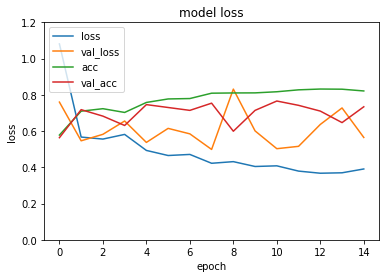

In [ ]:
#visualize loss, val_loss, acc, val_acc
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(hist1.history['loss'])
plt.plot(hist1.history['val_loss'])
plt.plot(hist1.history['accuracy'])
plt.plot(hist1.history['val_accuracy'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss', 'acc', 'val_acc'], loc='upper left')
plt.ylim([0.0, 1.2])
plt.show()

In [ ]:
#express numerically
loss_and_metrics1 = model1.evaluate(Val_1, Val_lbl, batch_size=32)
print('## evaluation loss and_metrics ##')
print(loss_and_metrics1)

8/8 [==============================] - 0s 8ms/step - loss: 0.5648 - accuracy: 0.7341
## evaluation loss and_metrics ##
[0.5647698640823364, 0.7341269850730896]


In [ ]:
#function for evaluate model
def TF(x):
  for i in x:
    if i >= 0.5:
      print("True")
    else:
      print("False")

#evaluate
prediction1 = model1.predict(eval_1)

print(prediction1)
print(TF(prediction1))

[[0.02571476]
 [0.11931819]
 [0.0772185 ]
 [0.6505257 ]
 [0.25485855]
 [0.02805167]
 [0.00909016]
 [0.04105526]
 [0.00096974]
 [0.07269681]]
False
False
False
True
False
False
False
False
False
False
None


In [ ]:
#get accuracy score with test set
from sklearn.metrics import accuracy_score

test_prediction1 = model1.predict(Test_1)
test_prediction1 = np.round(test_prediction1)

accuracy1 = accuracy_score(Test_lbl, test_prediction1)
print("Accuracy: " + str(accuracy1))

Accuracy: 0.7321428571428571


Multi-layer perceptron

I made model1 by adding several dense layers and I chose 'sigmoid' activation in last layer, not 'softmax' because I want binary classifying model.
While compiling my model, I selected 'binary_crossentropy' and 'adam' parameter because they performs better for binary classification.
I visualized model loss as a gragh and tested accuracy for test set.

It scored 0.732.

In [ ]:
#normalize group for CNN & deep CNN model
Train_2 = Train / 1000.0
Val_2 = Val / 1000.0
Test_2 = Test / 1000.0
eval_2 = eval / 1000.0

I only normalized train, validation, test, evaluation set because I think CNN and deep CNN model don't need reduced dimension.

In [ ]:
#import packages
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import Conv2D, MaxPooling2D, Flatten

#make 2nd model (CNN)
model2 = Sequential()
model2.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 16)))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Conv2D(32, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Flatten())
model2.add(Dense(256, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))

In [ ]:
#compile model
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#use checkpoint & early stopping for efficiency
model_dir = './model'
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
model_path2 = model_dir + "/CNN.model"
    
checkpoint2 = ModelCheckpoint(filepath=model_path2, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping2 = EarlyStopping(monitor='val_loss', patience=7)

In [ ]:
#fit model
hist2 = model2.fit(Train_2, Train_lbl, epochs=30, batch_size=32, 
                   validation_data=(Val_2, Val_lbl), callbacks=[checkpoint2, early_stopping2])

Epoch 1/30
71/71 [==============================] - ETA: 0s - loss: 0.5819 - accuracy: 0.7033
Epoch 00001: val_loss improved from inf to 0.54674, saving model to ./model/CNN.model
71/71 [==============================] - 4s 59ms/step - loss: 0.5819 - accuracy: 0.7033 - val_loss: 0.5467 - val_accuracy: 0.7579
Epoch 2/30
70/71 [============================>.] - ETA: 0s - loss: 0.4555 - accuracy: 0.7924
Epoch 00002: val_loss improved from 0.54674 to 0.48689, saving model to ./model/CNN.model
71/71 [==============================] - 4s 59ms/step - loss: 0.4559 - accuracy: 0.7923 - val_loss: 0.4869 - val_accuracy: 0.7698
Epoch 3/30
70/71 [============================>.] - ETA: 0s - loss: 0.3909 - accuracy: 0.8339
Epoch 00003: val_loss improved from 0.48689 to 0.37923, saving model to ./model/CNN.model
71/71 [==============================] - 4s 62ms/step - loss: 0.3908 - accuracy: 0.8342 - val_loss: 0.3792 - val_accuracy: 0.8135
Epoch 4/30
71/71 [==============================] - ETA: 0s - 

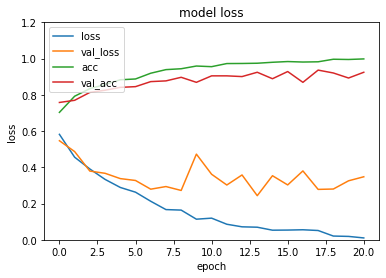

In [ ]:
#visualize loss, val_loss, acc, val_acc
plt.plot(hist2.history['loss'])
plt.plot(hist2.history['val_loss'])
plt.plot(hist2.history['accuracy'])
plt.plot(hist2.history['val_accuracy'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss', 'acc', 'val_acc'], loc='upper left')
plt.ylim([0.0, 1.2])
plt.show()

In [ ]:
#express numerically
loss_and_metrics2 = model2.evaluate(Val_2, Val_lbl, batch_size=32)
print('## evaluation loss and_metrics ##')
print(loss_and_metrics2)

8/8 [==============================] - 0s 12ms/step - loss: 0.3479 - accuracy: 0.9246
## evaluation loss and_metrics ##
[0.34786614775657654, 0.9246031641960144]


In [ ]:
#evaluate
prediction2 = model2.predict(eval_2)

print(prediction2)
print(TF(prediction2))

[[2.16037035e-04]
 [3.11774015e-03]
 [1.13505125e-02]
 [3.01247674e-05]
 [1.66302919e-03]
 [2.38594876e-05]
 [8.81642103e-04]
 [4.59765673e-01]
 [1.75299522e-06]
 [5.28085828e-02]]
False
False
False
False
False
False
False
False
False
False
None


In [ ]:
#get accuracy score with test set
test_prediction2 = model2.predict(Test_2)
test_prediction2 = np.round(test_prediction2)

accuracy2 = accuracy_score(Test_lbl, test_prediction2)
print("Accuracy: " + str(accuracy2))

Accuracy: 0.8714285714285714


CNN

I made model2 by adding several Conv2D, MaxPooling2D, Flatten, and Dense layers  and I chose 'sigmoid' activation in last layer, not 'softmax' because I want binary classifying model.
While compiling my model, I selected 'binary_crossentropy' and 'adam' parameter because they performs better for binary classification.
I visualized model loss as a gragh and tested accuracy for test set.

It scored 0.871.

In [ ]:
from keras.layers import Dropout

#make 3rd model (deep CNN)
model3 = Sequential()
model3.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32,32,16)))
model3.add(Conv2D(32, (3, 3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.25))
model3.add(Conv2D(64, (3, 3), activation='relu'))
model3.add(Conv2D(64, (3, 3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.25))
model3.add(Flatten())
model3.add(Dense(256, activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(1, activation='sigmoid'))

In [ ]:
#compile model
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#use checkpoint & early stopping for efficiency
model_dir = './model'
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
model_path3 = model_dir + "/deep CNN.model"
    
checkpoint3 = ModelCheckpoint(filepath=model_path3, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping3 = EarlyStopping(monitor='val_loss', patience=7)

In [ ]:
#fit model
hist3 = model3.fit(Train_2, Train_lbl, epochs=30, batch_size=32, 
                   validation_data=(Val_2, Val_lbl), callbacks=[checkpoint3, early_stopping3])

Epoch 1/30
71/71 [==============================] - ETA: 0s - loss: 0.6409 - accuracy: 0.6552
Epoch 00001: val_loss improved from inf to 0.59366, saving model to ./model/deep CNN.model
71/71 [==============================] - 10s 144ms/step - loss: 0.6409 - accuracy: 0.6552 - val_loss: 0.5937 - val_accuracy: 0.6706
Epoch 2/30
71/71 [==============================] - ETA: 0s - loss: 0.5442 - accuracy: 0.7584
Epoch 00002: val_loss improved from 0.59366 to 0.50678, saving model to ./model/deep CNN.model
71/71 [==============================] - 10s 141ms/step - loss: 0.5442 - accuracy: 0.7584 - val_loss: 0.5068 - val_accuracy: 0.7778
Epoch 3/30
71/71 [==============================] - ETA: 0s - loss: 0.4787 - accuracy: 0.7866
Epoch 00003: val_loss did not improve from 0.50678
71/71 [==============================] - 9s 124ms/step - loss: 0.4787 - accuracy: 0.7866 - val_loss: 0.5396 - val_accuracy: 0.7341
Epoch 4/30
71/71 [==============================] - ETA: 0s - loss: 0.4480 - accuracy:

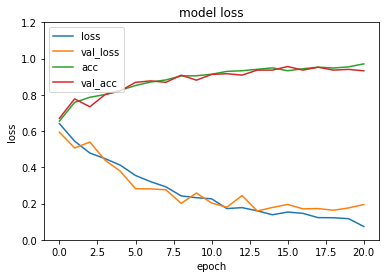

In [ ]:
#visualize loss, val_loss, acc, val_acc
plt.plot(hist3.history['loss'])
plt.plot(hist3.history['val_loss'])
plt.plot(hist3.history['accuracy'])
plt.plot(hist3.history['val_accuracy'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss', 'acc', 'val_acc'], loc='upper left')
plt.ylim([0.0, 1.2])
plt.show()

In [ ]:
#express numerically
loss_and_metrics3 = model3.evaluate(Val_2, Val_lbl, batch_size=32)
print('## evaluation loss and_metrics ##')
print(loss_and_metrics3)

8/8 [==============================] - 0s 28ms/step - loss: 0.1947 - accuracy: 0.9325
## evaluation loss and_metrics ##
[0.19465745985507965, 0.932539701461792]


In [ ]:
#evaluate
prediction3 = model3.predict(eval_2)

print(prediction3)
print(TF(prediction3))

[[4.6847463e-03]
 [4.3731928e-04]
 [1.1657488e-01]
 [6.1817755e-06]
 [4.2209029e-04]
 [1.0415018e-03]
 [1.0945618e-02]
 [1.9572526e-02]
 [1.6920835e-02]
 [6.0739040e-02]]
False
False
False
False
False
False
False
False
False
False
None


In [ ]:
#get accuracy score with test set
test_prediction3 = model3.predict(Test_2)
test_prediction3 = np.round(test_prediction3)

accuracy3 = accuracy_score(Test_lbl, test_prediction3)
print("Accuracy: " + str(accuracy3))

Accuracy: 0.9142857142857143


deep CNN

I made model3 by adding more Conv2D, MaxPooling2D, Flatten, and Dense layers and I chose 'sigmoid' activation in last layer, not 'softmax' because I want binary classifying model.
I also used dropout layer to avoid model to be overfitted.
While compiling my model, I selected 'binary_crossentropy' and 'adam' parameter because they performs better for binary classification.
I visualized model loss as a gragh and tested accuracy for test set.

It scored 0.914

The limitation of multilayer perceptron is that it lacks the ability to learn and predict images. It is an inefficient problem to perform operations on the same image each time even if the position of objects in the image varies slightly. By recognizing as a completely different input as the location changes, I think multilayer perceptron cannot perform better than CNN model.

However, CNN is a powerful algorithm for image recognition. Convolution process happens while data pass between input and hidden layer. It is much more sparsed layer than fully connected layer. In addition, Pooling process makes dimension shrinkage one more time. The reduced dimension results low computation, translation invariance, transformation invariance. By these newly added layers make great performance of CNN model in image process.

In [ ]:
#save model architecture
model_json = model3.to_json()
with open("model.json", "w") as json_file : 
    json_file.write(model_json)

In [ ]:
#save model weights
model3.save_weights("model.h5")

In [ ]:
#summary of best model
model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 30, 30, 32)        4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 10, 10, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 64)         

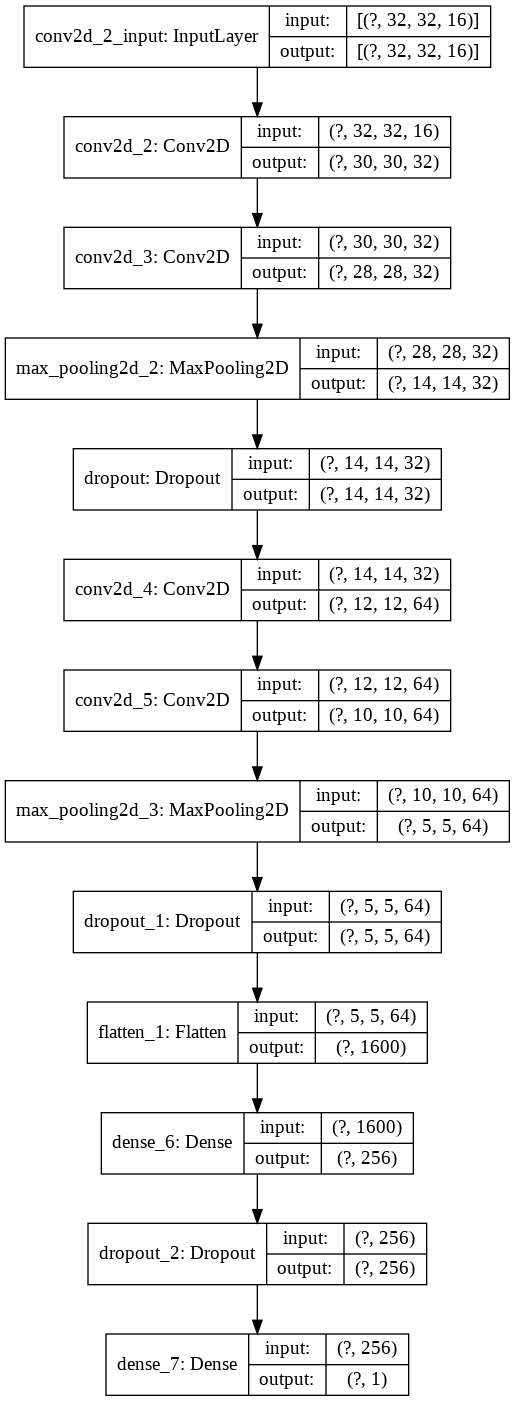

In [ ]:
#plot best model
tf.keras.utils.plot_model(
    model3, to_file='model3.png', show_shapes=True, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=96
)

I chose model3 (deep CNN model) to my best model.

Then I searched for summary and plot of my best model.
I have noticed that only Conv2D and Dense layers are increasing the depth(# param) of the model. It increased to 409856 in dense_6 layer and decreased to 257 in last dense layer.

After looking at the plot of my model, I could understand about the role of each layers and the change of input & output shape vector easily.